In [171]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
import sys
sys.path.append('../src/')
from permutation_random_chr import get_df_gene_position,get_random_gene_list
from Preprocessing import load_GENE_expression
df_exp, dict_pop = load_GENE_expression('LTRC',chromosome='All',path_data='../data/')
set_genes_in_gex = set(df_exp.index)
start_pos = 74748153-2*10**6 #rs4585380
stop_pos = 144567946+2*10**6 #rs13140176
length_area = stop_pos - start_pos
df_gene_position,n_genes,lenght_area,genes_btc_hhip = get_df_gene_position(set_genes_in_gex,start_pos,stop_pos)



def load_perm(dir_results,random_type,pop,minL,nreg,n_rep = 1000,recompute=False):
    file_pickle_name = dir_results + '%s_%s_minL_%s_nreg_%s_rep_%s'%(random_type,pop,minL,nreg,n_rep) + '.pckl'


    if os.path.isfile(file_pickle_name) and not recompute:
        with open(file_pickle_name,'rb') as f:
            dict_res = pickle.load(f)
        density_rep = dict_res['density_rep']
        density= dict_res['density_pcor']
        
    
    else:
        density_rep = []
        for rep in tqdm(range(n_rep)):
            file_name = '%s_%s_minL_%s_nreg_%s_rep_%s.csv'%(random_type,pop,minL,nreg,rep)
            df_pcor_rep = pd.read_csv(dir_results+file_name,index_col=0)
            pcor_rep = df_pcor_rep.values[np.triu_indices(df_pcor_rep.shape[0],1)]
            pcor_rep = np.mean((np.abs(pcor_rep)>0.1))
            if rep==0:
                density= pcor_rep
            else:
                density_rep.append(pcor_rep)
        with open(file_pickle_name,'wb') as f:
            pickle.dump({'density_rep':density_rep, 
                         'density_pcor':density_pcor},f)
                
    return density_rep,density_pcor
    
def Analysis_rnd_gene_set_density(gex_name,random_type,pop,minL,nreg,n_rep = 1000,recompute=False):
    dir_results = dir_pcorr_output+'Permutation/%s/'%gex_name
    density_rep,density= load_perm(dir_results,random_type,pop,minL,nreg,n_rep,recompute)

    plt.axvline(density_pcor,label='4q COPD risk region',c='red',linestyle='dashed',linewidth=3)
    plt.hist(density_rep,alpha=.5,bins=30,label= 'Randomly selected regions')
    plt.title('Network Densities Distribution',{'fontsize': 15})
    plt.xlabel('Network Density\n(a)',{'fontsize': 15})
    plt.legend(loc='upper center')
    return density_rep, density_pcor
    

def Analysis_rnd_gene_set_diff(gex_name,dir_pcorr_output,random_type,minL,nreg,n_rep = 1000,recompute=False,case='case',control='control',thr_edge=0.15):
    dir_results = dir_pcorr_output+'Permutation/%s/'%gex_name
    file_pickle_name = dir_results + 'Difference_%s_minL_%s_nreg_%s_rep_%s'%(random_type,minL,nreg,n_rep) + '.pckl'

    if os.path.isfile(file_pickle_name) and not recompute:
        with open(file_pickle_name,'rb') as f:
            dict_res = pickle.load(f)
        diff_control_case = dict_res['diff_control_case']
        diff= dict_res['diff_pcor']


    else:
        
        diff= []
        for rep in tqdm(range(n_rep)):
            try:
                file_name = '%s/minL_%s_nreg_%s/%s_rep_%s.csv'%(random_type,minL,nreg,case,rep)
                df_pcor_control_rep = pd.read_csv(dir_results+file_name,index_col=0).abs()
                np.fill_diagonal(df_pcor_control_rep.values,0)
                file_name = '%s/minL_%s_nreg_%s/%s_rep_%s.csv'%(random_type,minL,nreg,control,rep)
                df_pcor_case_rep = pd.read_csv(dir_results+file_name,index_col=0).abs()
                np.fill_diagonal(df_pcor_case_rep.values,0)


                diff_control_case_rep =((df_pcor_control_rep>thr_edge).astype(int) - (df_pcor_case_rep>thr_edge).astype(int)).abs().sum().sum()/2
                union = (((df_pcor_control_rep>thr_edge).astype(int) + (df_pcor_case_rep>thr_edge).astype(int))!=0).sum().sum()
                diff_control_case_rep = diff_control_case_rep/union
                if rep ==0:
                    diff_control_case = diff_control_case_rep
                else:
                    diff_pcor.append(diff_control_case_rep)
            except:
                continue
        with open(file_pickle_name,'wb') as f:
            pickle.dump({'diff_control_case':diff_control_case, 
                     'diff_pcor':diff_pcor},f)

    plt.axvline(diff_control_case,label='4q COPD risk region',c='red',linestyle='dashed',linewidth=3)
    plt.hist(diff_pcor,alpha=.5,bins=30,label= 'Randomly selected regions')
    plt.title('Network differences in cases and controls',{'fontsize': 15})
    plt.xlabel('Jaccard Distance\n(b)',{'fontsize': 15})
    plt.legend(loc='upper center')
    return diff_pcor, diff_control_case

In [267]:
from scipy.stats import kendalltau
import scipy
import networkx as nx

def jaccard_dist(a,b,thr_edge):
    a=a.abs()
    b=b.abs()
    np.fill_diagonal(a.values,0)
    np.fill_diagonal(b.values,0)
    dist =((a>thr_edge).astype(int) - (b>thr_edge).astype(int)).abs().sum().sum()/2
    union = (((a>thr_edge).astype(int) + (b>thr_edge).astype(int))!=0).sum().sum()
    dist = dist/union
    return dist
    

def get_random_analysis(gex_name,dir_pcorr_output,random_type,minL,nreg,thr_edge,n_rep = 1000,recompute=False,filter_genes=None):
    dir_results = dir_pcorr_output+'%s/'%gex_name
    file_pickle_name = dir_results + 'Results_%s_minL_%s_nreg_%s_rep_%s'%(random_type,minL,nreg,n_rep) + '.pckl'

    if os.path.isfile(file_pickle_name) and not recompute:
        with open(file_pickle_name,'rb') as f:
            dict_res = pickle.load(f)
        dist_cont_ch4 = dict_res['dist_cont_ch4']
        dist_cont_rnd= dict_res['dist_cont_rnd']
        dist_disc_ch4= dict_res['dist_disc_ch4']
        dist_disc_rnd= dict_res['dist_disc_rnd']


    else:
        
        dist_disc_rnd= []
        dist_cont_rnd= []
        
        for rep in tqdm(range(n_rep)):

            file_name = '%s/minL_%s_nreg_%s/case_rep_%s.csv'%(random_type,minL,nreg,rep)
            df_pcor_control_rep = pd.read_csv(dir_results+file_name,index_col=0).abs()
            tmp_genes_list = df_pcor_control_rep.index
            if not filter_genes is None:
                tmp_genes_list =tmp_genes_list.intersection(filter_genes)
            df_pcor_control_rep = df_pcor_control_rep.loc[tmp_genes_list,tmp_genes_list]
            np.fill_diagonal(df_pcor_control_rep.values,0)
            file_name = '%s/minL_%s_nreg_%s/control_rep_%s.csv'%(random_type,minL,nreg,rep)
            df_pcor_case_rep = pd.read_csv(dir_results+file_name,index_col=0).abs().loc[tmp_genes_list,tmp_genes_list]
            np.fill_diagonal(df_pcor_case_rep.values,0)

            triu_index = np.triu_indices_from(df_pcor_case_rep,1)
            np_case_triu = df_pcor_case_rep.values[triu_index]
            np_control_triu = df_pcor_control_rep.values[triu_index]

            #nt_distance = np.corrcoef(np_case_triu,np_control_triu)[0,1]
            #nt_distance = np.linalg.norm(np_case_triu-np_control_triu)
            nt_distance = np.mean(np.abs(np_case_triu-np_control_triu))
            nt_jaccard_dist = jaccard_dist(np_control_triu,np_case_triu,thr_edge)
            if rep == 0:
                dist_cont_ch4 = nt_distance
                dist_disc_ch4= nt_jaccard_dist
            else:
                dist_cont_rnd.append(nt_distance)
                dist_disc_rnd.append(nt_jaccard_dist)

        print(len(sim_rnd_pcor))
        with open(file_pickle_name,'wb') as f:
            pickle.dump({'dist_cont_ch4':dist_cont_ch4, 
                         'dist_cont_rnd':dist_cont_rnd,
                         'dist_disc_rnd':dist_disc_rnd,
                     'dist_disc_ch4':dist_disc_ch4},f)
            
   

    plt.axvline(dist_cont_ch4,label='4q COPD risk region',c='red',linestyle='dashed',linewidth=3)
    plt.hist(dist_cont_rnd,alpha=.5,bins=30,label= 'Randomly selected regions')
    plt.title('Partial Correlations cases and controls similarity',{'fontsize': 15})
    plt.xlabel('Similarity\n(a)',{'fontsize': 15})
    plt.legend(loc='upper center')
    plt.show()
    plt.axvline(dist_disc_ch4,label='4q COPD risk region',c='red',linestyle='dashed',linewidth=3)
    plt.hist(dist_disc_rnd,alpha=.5,bins=30,label= 'Randomly selected regions')
    plt.title('Partial Correlations cases and controls similarity',{'fontsize': 15})
    plt.xlabel('Similarity\n(a)',{'fontsize': 15})
    plt.legend(loc='upper center')
    plt.show()
    return dist_cont_ch4,dist_cont_rnd,dist_disc_ch4,dist_disc_rnd

def plot_info(df_info,df_gene_position,perm_array,obs_value,random_type):
    fig, axs = plt.subplots(1, 2,figsize=[15,5])
    axs[0].hist(df_info.chrom.sort_values(),bins=max(df_info.chrom),density=True,alpha=.7,label='Number of random \nregions selected')
    axs[0].hist(df_gene_position.chr.astype(int),bins=max(df_info.chrom),density=True,label='Genes in Chromosome',alpha=.5)
    axs[0].set_title('Random Chromosomes selected')
    axs[0].tick_params(labelrotation=45)
    axs[0].set_xticks(df_info.chrom.unique())
    axs[0].set_xlabel('Chromosome\n(a)')
    axs[0].legend()
    if random_type == 'same_region_ngenes':
        axs[1].hist(df_info.len_re/10**6)
        axs[1].set_title('Random region length')
        axs[1].set_xlabel('Magabases\n(b)')
    else:
        axs[1].hist(df_info.ng)
        axs[1].set_title('Random region number of genese')
        axs[1].set_xlabel('N genes\n(b)')
    plt.savefig('../figures/S. Figure 3 Region Sampling details.pdf',bbox_inches= 'tight')
    plt.show()
    import seaborn as sns
    fig, axs = plt.subplots(1, 2,figsize=[15,5])

    df_info = df_info.sort_values('it')
    df_info['perm_array'] = perm_array
    if random_type == 'same_region_ngenes':
        sns.regplot(data=df_info,x='len_re',y='perm_array',ax=axs[0])
        axs[0].set_ylabel('score')
        axs[0].set_title('Cases/controls difference in Ch4 vs random regions')
        axs[0].set_xlabel('Region length')
        axs[0].scatter(x=length_area,y=obs_value,c='r',s=30)
    else:
        sns.regplot(data=df_info,x='ng',y='perm_array',ax=axs[0])
        axs[0].set_ylabel('score')
        axs[0].set_title('Cases/controls difference in Ch4 vs random regions')
        axs[0].set_xlabel('N genes')
        axs[0].scatter(x=n_genes,y=obs_value,c='r',s=30)
    df_info.plot.scatter(x='chrom',y='perm_array',ax=axs[1])
    axs[1].set_xticks(df_info.chrom.unique())
    axs[1].set_ylabel('score')
    axs[1].scatter(x=4,y=obs_value,c='r',s=30)

    axs[1].set_title('Cases/controls difference in Ch4 vs random regions')
    plt.show()
    #df_info.plot.scatter(x='chrom',y='len_re')

In [262]:
dir_pcorr_output = "/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_same_cont_genes/"
for n in [10,1,5,0,25,50,75,100]:
    for m in [1,0.01,0.1,0,10]:
        dist_cont_ch4,dist_cont_rnd,disc_dist_ch4,disc_dist_rnd= get_random_analysis('LTRC',dir_pcorr_output,random_type=random_type,recompute =True,
                                                                          minL=m,nreg=n,n_rep = 1000,thr_edge = .15,filter_genes=used_old_genes)
        plot_info(df_info,df_gene_position,dist_cont_rnd, dist_cont_ch4,random_type=random_type)
        plot_info(df_info,df_gene_position,disc_dist_rnd, disc_dist_ch4,random_type=random_type)

        print('Distance continous:',dist_cont_ch4)
        print('Pvalue:',1-np.mean(dist_cont_ch4 >= np.array(dist_cont_rnd)))
        #plt.savefig('../figures/Figure 7b.pdf',bbox_inches= 'tight')
        print('Jaccard Distance observed:',disc_dist_ch4)
        print('Pvalue:',1-np.mean(disc_dist_ch4 >= np.array(disc_dist_rnd)))
        

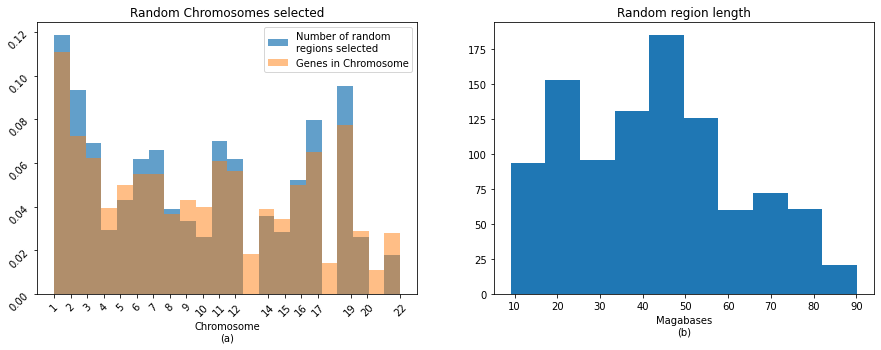

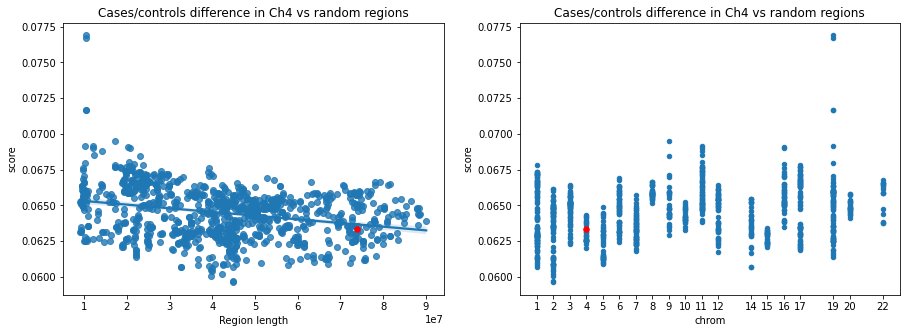

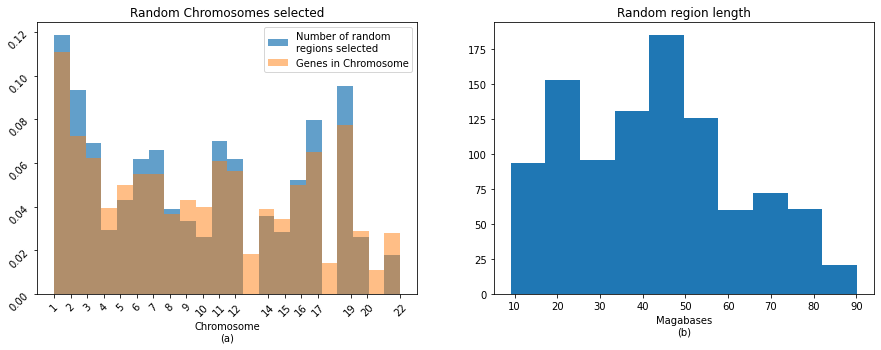

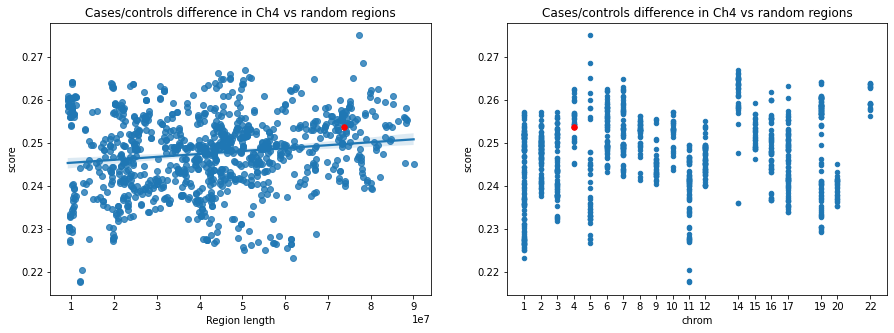

In [270]:
used_old_genes = set(df_gene_position_old.geneName)

n=10
m=1
random_type = 'same_region_ngenes'
dir_pcorr_output = '/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_same_cont_genes/Permutation/'
df_info = pd.read_csv(dir_pcorr_output + 'LTRC/%s/minL_%i_nreg_%i/Info_sampling.csv'%(random_type,m,n),index_col=0)
dist_cont_ch4,dist_cont_rnd,disc_dist_ch4,disc_dist_rnd= get_random_analysis('LTRC',dir_pcorr_output,random_type=random_type,recompute =True,
                                                                          minL=m,nreg=n,n_rep = 1000,thr_edge = .15,filter_genes=used_old_genes)
plot_info(df_info,df_gene_position,dist_cont_rnd, dist_cont_ch4,random_type=random_type)
plot_info(df_info,df_gene_position,disc_dist_rnd, disc_dist_ch4,random_type=random_type)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:46<00:00,  9.41it/s]


999


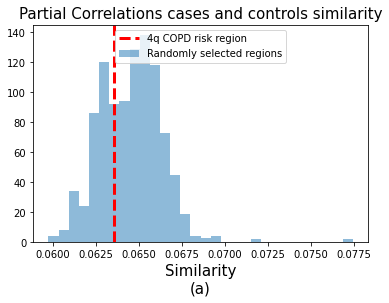

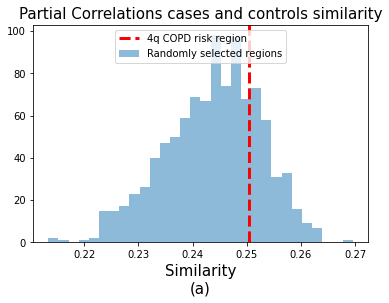

In [348]:
used_old_genes = set(df_gene_position_old.geneName)

n=10
m=1
random_type = 'same_region_ngenes'
dir_pcorr_output = '/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_same_cont_genes_with_intercept_and_beta/Permutation/'
#df_info = pd.read_csv(dir_pcorr_output + 'LTRC/%s/minL_%i_nreg_%i/Info_sampling.csv'%(random_type,m,n),index_col=0)
dist_cont_ch4,dist_cont_rnd,disc_dist_ch4,disc_dist_rnd= get_random_analysis('LTRC',dir_pcorr_output,random_type=random_type,recompute =True,
                                                                          minL=m,nreg=n,n_rep = 1000,thr_edge = .15,filter_genes=used_old_genes)
#plot_info(df_info,df_gene_position,dist_cont_rnd, dist_cont_ch4,random_type=random_type)
#plot_info(df_info,df_gene_position,disc_dist_rnd, disc_dist_ch4,random_type=random_type)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.54it/s]


999


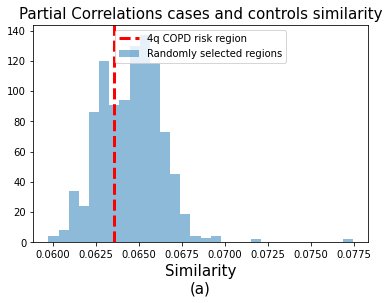

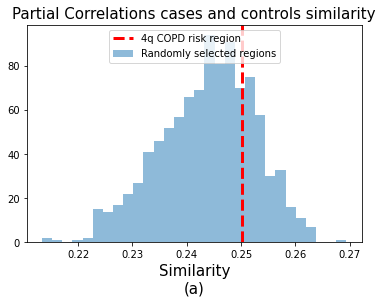

In [349]:
used_old_genes = set(df_gene_position_old.geneName)

n=10
m=1
random_type = 'same_region_ngenes'
dir_pcorr_output = '/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_same_cont_genes_with_intercept/Permutation/'
#df_info = pd.read_csv(dir_pcorr_output + 'LTRC/%s/minL_%i_nreg_%i/Info_sampling.csv'%(random_type,m,n),index_col=0)
dist_cont_ch4,dist_cont_rnd,disc_dist_ch4,disc_dist_rnd= get_random_analysis('LTRC',dir_pcorr_output,random_type=random_type,recompute =True,
                                                                          minL=m,nreg=n,n_rep = 1000,thr_edge = .15,filter_genes=used_old_genes)
#plot_info(df_info,df_gene_position,dist_cont_rnd, dist_cont_ch4,random_type=random_type)
#plot_info(df_info,df_gene_position,disc_dist_rnd, disc_dist_ch4,random_type=random_type)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.76it/s]


999


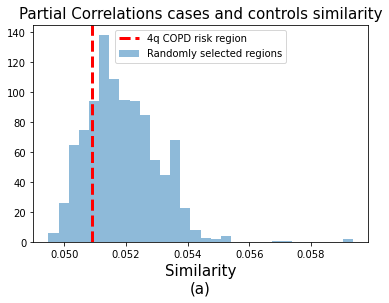

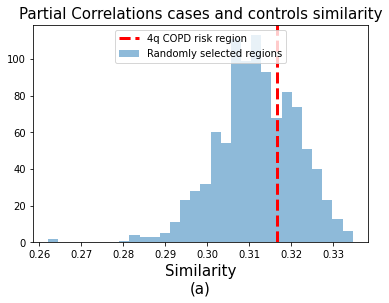

In [350]:
used_old_genes = set(df_gene_position_old.geneName)

n=10
m=1
random_type = 'same_region_ngenes'
dir_pcorr_output = '/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_new/Permutation/'
#df_info = pd.read_csv(dir_pcorr_output + 'LTRC/%s/minL_%i_nreg_%i/Info_sampling.csv'%(random_type,m,n),index_col=0)
dist_cont_ch4,dist_cont_rnd,disc_dist_ch4,disc_dist_rnd= get_random_analysis('LTRC',dir_pcorr_output,random_type=random_type,recompute =True,
                                                                          minL=m,nreg=n,n_rep = 1000,thr_edge = .15,filter_genes=used_old_genes)
#plot_info(df_info,df_gene_position,dist_cont_rnd, dist_cont_ch4,random_type=random_type)
#plot_info(df_info,df_gene_position,disc_dist_rnd, disc_dist_ch4,random_type=random_type)


In [382]:
old = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output/Permutation/LTRC/same_region_ngenes_control_minL_1_nreg_10_rep_0.csv',index_col=0)
new = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_new/Permutation/LTRC/same_region_ngenes/minL_1_nreg_10/control_rep_0.csv',index_col=0)

In [383]:
np.abs(old - new.loc[old.index,old.index]).max().max()

5.551115123125783e-16

In [606]:
df_info = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_new/Permutation/LTRC/%s/minL_%i_nreg_%i/Info_sampling.csv'%('same_region_ngenes',1,10),index_col=0)
dict_rep_old = {'case':{},'control':{}} 
dict_rep_new = {'case':{},'control':{}}
for i in tqdm(range(1000)):
    dict_rep_new['case'][i] = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_new/Permutation/LTRC/scattered_same_ngenes/minL_1_nreg_10/case_rep_%i.csv'%i,index_col=0)
    dict_rep_new['control'][i] = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_new/Permutation/LTRC/scattered_same_ngenes/minL_1_nreg_10/control_rep_%i.csv'%i,index_col=0)
    dict_rep_old['case'][i] = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output/Permutation/LTRC/same_region_ngenes_case_minL_1_nreg_10_rep_%i.csv'%i,index_col=0)
    dict_rep_old['control'][i] = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output/Permutation/LTRC/same_region_ngenes_control_minL_1_nreg_10_rep_%i.csv'%i,index_col=0)
    if len(old_rep.index.intersection(new_rep.index))>150:
        pass


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:30<00:00,  6.62it/s]


In [627]:
def jaccard_dist(a,b,thr_edge):
    a=a.abs()
    b=b.abs()
    np.fill_diagonal(a.values,0)
    np.fill_diagonal(b.values,0)
    dist =((a>thr_edge).astype(int) - (b>thr_edge).astype(int)).abs().sum().sum()/2
    union = (((a>thr_edge).astype(int) + (b>thr_edge).astype(int))!=0).sum().sum()
    dist = dist/union
    return dist
list_diff_new = []
list_diff_old = []
not_found=True
for i in range(1000):
    new_case = dict_rep_new['case'][i]
    tmp_used_genes= new_case.index.intersection(used_genes)
    new_case = new_case.loc[tmp_used_genes,tmp_used_genes]
    new_control = dict_rep_new['control'][i].loc[tmp_used_genes,tmp_used_genes]
    #for j  in range(1000):
    old_case = dict_rep_old['case'][i]
    old_control = dict_rep_old['control'][i]
    list_diff_old.append(jaccard_dist(old_case,old_control,0.1))
    list_diff_new.append(jaccard_dist(new_case,new_control,0.1))
        
    #list_genes = old_case.index.intersection(new_case.index)

    if False:#len(list_genes)>180:
        #print(len(list_genes))
        #print(np.abs(old_case.loc[list_genes,list_genes] - new_case.loc[list_genes,list_genes]).max().max())
        #print(np.abs(old_control.loc[list_genes,list_genes] - new_control.loc[list_genes,list_genes]).max().max())
        #list_diff_old.append(np.mean(np.mean(np.abs(old_case-old_control))))
        #list_diff_new.append(np.mean(np.mean(np.abs(new_case-new_control))))
        list_diff_old.append(jaccard_dist(old_case,old_control,0.1))
        list_diff_new.append(jaccard_dist(new_case,new_control,0.1))

        #print()
        #print()
        #print()
        not_found=False
        break
    if False:
        not_found=True
        print('Not found')

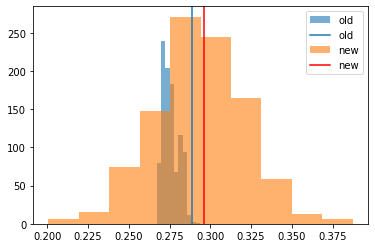

In [628]:
plt.hist(list_diff_old[1:],alpha=.6,label='old')
plt.axvline(list_diff_old[0],label='old')
plt.hist(list_diff_new[1:],alpha=.6,label='new')
plt.axvline(list_diff_new[0],c='r',label='new')
plt.legend()

In [609]:
list_diff_new = []
list_diff_old = []
for i  in tqdm(range(1000)):
    old_case = dict_rep_old['case'][i]
    old_control = dict_rep_old['control'][i]
    max_inter = (0,0)
    for j in range(1000):
        new_case = dict_rep_new['case'][j]
        new_control = dict_rep_new['control'][j]
    
        list_genes = old_case.index.intersection(new_case.index)
        if len(list_genes)>max_inter[0]:
            max_inter= (len(list_genes),j)
    #print(max_inter)
    if max_inter[0]==0:
        break
    j=max_inter[1]
    list_diff_old.append(jaccard_dist(dict_rep_old['case'][j],dict_rep_old['control'][j],0.1))
    list_diff_new.append(jaccard_dist(dict_rep_new['case'][j],dict_rep_new['control'][j],0.1))
    
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:13<00:00,  5.16it/s]


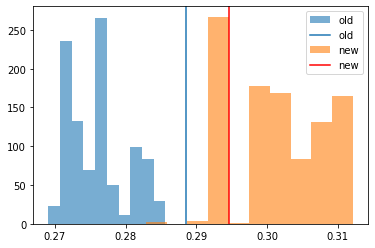

In [610]:
plt.hist(list_diff_old[1:],alpha=.6,label='old')
plt.axvline(list_diff_old[0],label='old')
plt.hist(list_diff_new[1:],alpha=.6,label='new')
plt.axvline(list_diff_new[0],c='r',label='new')
plt.legend()

In [611]:
list_diff_new[0]

0.29463611181062704

In [614]:
a = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_same_cont_genes/Permutation/LTRC/same_region_ngenes/minL_1_nreg_10/case_rep_%i.csv'%0,index_col=0)
b = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_same_cont_genes/Permutation/LTRC/same_region_ngenes/minL_1_nreg_10/control_rep_%i.csv'%0,index_col=0)

In [617]:
jaccard_dist(a,b,0.1)

0.2345054000981836

In [624]:
dict_rep_new['case'][0].loc[a.index,a.index]

,RPL34,UBE2D3,BBS7,PLK4,FAM13A-AS1,USP53,SEPTIN11,SMARCA5,RAB33B,ADH5,...,INTU,SEC24B-AS1,C4orf33,NDNF,AREG,CNOT6L,BMP3,LIN54,PKD2,TRAM1L1
RPL34,1.000000,-0.037933,-0.004988,-0.032442,0.004177,0.032878,0.064984,-0.143711,0.074025,0.082211,...,0.075063,-0.013516,0.023543,-0.029455,-0.055496,-0.042511,-0.007719,-0.061945,0.194678,-0.019833
UBE2D3,-0.037933,1.000000,0.035599,-0.047589,0.078794,-0.110345,-0.120834,-0.056045,0.060102,-0.113796,...,0.013032,0.028884,0.049353,0.051802,0.011477,-0.014108,0.153041,0.070904,-0.074051,-0.066311
BBS7,-0.004988,0.035599,1.000000,0.048953,0.029302,0.055803,0.021461,0.120554,0.116367,0.099729,...,0.056117,-0.050925,0.101460,0.086649,-0.105695,-0.003895,-0.025222,0.141510,0.070960,-0.067728
PLK4,-0.032442,-0.047589,0.048953,1.000000,-0.006826,0.033232,-0.006930,-0.079810,0.008895,0.122469,...,-0.080186,0.059892,-0.003875,-0.038117,-0.051385,0.028040,-0.047118,-0.021663,-0.005923,0.037346
FAM13A-AS1,0.004177,0.078794,0.029302,-0.006826,1.000000,0.009939,-0.276201,-0.004416,0.131265,-0.046217,...,0.227618,0.214632,-0.052706,0.016905,0.045434,-0.100456,-0.038487,0.093031,-0.305847,-0.218191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CNOT6L,-0.042511,-0.014108,-0.003895,0.028040,-0.100456,-0.020028,0.125143,0.127175,0.151327,0.032630,...,-0.134909,-0.144691,0.034780,-0.119669,0.013208,1.000000,-0.064435,0.083505,0.001239,-0.029828
BMP3,-0.007719,0.153041,-0.025222,-0.047118,-0.038487,-0.126877,-0.098263,0.227365,-0.051845,-0.011565,...,0.054345,0.078686,0.075414,0.217295,0.096677,-0.064435,1.000000,-0.163983,-0.038198,0.057923
LIN54,-0.061945,0.070904,0.141510,-0.021663,0.093031,0.008404,0.071682,0.019841,0.126122,0.094292,...,-0.010349,-0.061576,0.109422,-0.080515,-0.185546,0.083505,-0.163983,1.000000,-0.001438,-0.106967
PKD2,0.194678,-0.074051,0.070960,-0.005923,-0.305847,0.286049,0.240729,0.006860,0.099758,0.075179,...,-0.133362,-0.023969,-0.034302,-0.040656,-0.017853,0.001239,-0.038198,-0.001438,1.000000,0.081442


In [ ]:
dir_pcorr_output_old = '/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output/Permutation/'
diff_pcor_rep, diff_control_case = Analysis_rnd_gene_set_diff('LTRC',dir_pcorr_output,random_type=random_type,recompute =True,
                                                                          minL=m,nreg=n,n_rep = 1000,thr_edge = .15)


In [534]:
dir_results_old = '/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output/Permutation/LTRC/'
random_type='same_region_ngenes'
df_info_old = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output/Permutation/LTRC/Info_sampling_same_region_ngenes_minL_1_nreg_10.csv',index_col=0)
diff_pcor= []
n_rep=1000
used_genes=set()
for rep in tqdm(range(n_rep)):
    file_name = '%s_%s_minL_%s_nreg_%s_rep_%s.csv'%(random_type,'case',m,n,rep)
    df_pcor_case_rep = pd.read_csv(dir_results_old+file_name,index_col=0).abs()
    used_genes = used_genes.union(df_pcor_case_rep.index)
    np.fill_diagonal(df_pcor_case_rep.values,0)

    file_name = '%s_%s_minL_%s_nreg_%s_rep_%s.csv'%(random_type,'control',m,n,rep)
    df_pcor_control_rep = pd.read_csv(dir_results_old+file_name,index_col=0).abs()
    np.fill_diagonal(df_pcor_control_rep.values,0)
    used_genes = used_genes.union(df_pcor_control_rep.index)

    diff_control_case_rep =((df_pcor_control_rep>thr_edge).astype(int) - (df_pcor_case_rep>thr_edge).astype(int)).abs().sum().sum()/2
    union = (((df_pcor_control_rep>thr_edge).astype(int) + (df_pcor_case_rep>thr_edge).astype(int))!=0).sum().sum()
    diff_control_case_rep = diff_control_case_rep/union
    if rep ==0:
        diff_control_case = diff_control_case_rep
    else:
        diff_pcor.append(diff_control_case_rep)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.86it/s]


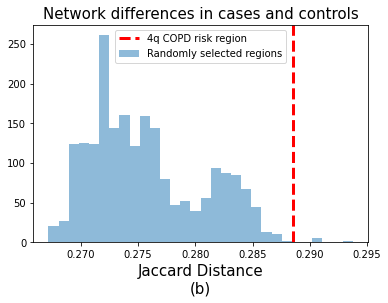

In [510]:
plt.axvline(diff_control_case,label='4q COPD risk region',c='red',linestyle='dashed',linewidth=3)
plt.hist(diff_pcor,alpha=.5,bins=30,label= 'Randomly selected regions')
plt.title('Network differences in cases and controls',{'fontsize': 15})
plt.xlabel('Jaccard Distance\n(b)',{'fontsize': 15})
plt.legend(loc='upper center')

In [537]:
np.mean(diff_control_case<=diff_pcor)

0.003003003003003003

In [538]:
diff_control_case

0.2885375494071146

(array([172., 510., 426., 383., 139., 238., 197.,  25.,   5.,   2.]),
 array([0.26716294, 0.26982239, 0.27248183, 0.27514127, 0.27780071,
        0.28046015, 0.28311959, 0.28577903, 0.28843847, 0.29109791,
        0.29375735]),
 <BarContainer object of 10 artists>)

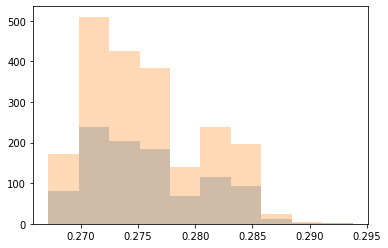

In [522]:
plt.hist(list_diff_old,alpha=.3)
plt.hist(diff_pcor,alpha=.3)

In [525]:
len(diff_pcor)

2097

In [206]:
start_pos

72748153

In [207]:
stop_pos

146567946

In [215]:
df_gene_position_old = pd.read_csv('../../old_Partial_Correlation/data/Gene_location_clean.txt',index_col=0)
(df_gene_position_old.pipe(lambda x : x[x['#chrom']=='chr4'])
                    .pipe(lambda x : x.query('chromStart<=@stop_pos and chromStart>=@start_pos and geneName in @set_genes_in_gex')))

,#chrom,chromStart,geneName
4700,chr4,73058116,COX18
4701,chr4,73076233,ANKRD17
4705,chr4,73576237,RASSF6
4706,chr4,73740658,CXCL8
4709,chr4,73869470,CXCL1
...,...,...,...
4975,chr4,145514613,SMAD1
4976,chr4,145639139,MMAA
4978,chr4,145763109,ZNF827
4979,chr4,146182921,LSM6


In [229]:
df_compare = df_gene_position_old.merge(df_gene_position, on ='geneName',how='outer').query('geneName in @set_genes_in_gex')

In [239]:
df_compare[np.any(df_compare.isna(),axis=1)]#.chr.value_counts()

,#chrom,chromStart,geneName,chrStart,chrEnd,chr
21764,NaN,NaN,LINC00526,5236724.0,5238598.0,18
21765,NaN,NaN,DUXAP8,15826566.0,15827187.0,22
21766,NaN,NaN,SHLD1,5750393.0,5864395.0,20
21767,NaN,NaN,MIATNB,26672747.0,26780893.0,22
21768,NaN,NaN,DUXAP10,19268853.0,19337730.0,14
...,...,...,...,...,...,...
23333,NaN,NaN,SEC22B4P,146321842.0,146328211.0,1
23334,NaN,NaN,CCT8P1,147203276.0,147204932.0,1
23335,NaN,NaN,MRPL20-AS1,1399515.0,1402046.0,1
23336,NaN,NaN,THBS3-AS1,155194996.0,155205495.0,1


In [241]:
tmp_df = pd.read_csv('/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_same_cont_genes/Permutation/LTRC/same_region_ngenes/minL_0.1_nreg_10/case_rep_100.csv',index_col=0)

In [242]:
tmp_df

,CLDN7,MAP2K3,NF1,C17orf75,MED9,NATD1,ALDH3A1,PEMT,TRIM16L,NTN1,...,BLTP2,ALKBH5,MYOCD,TP53I13,RASD1,PIK3R5-DT,MIEF2,RNF135,AKAP10,TNFSF12
CLDN7,0.000000,0.107535,-0.409572,0.090892,-0.142208,-0.358262,0.131249,-0.075496,0.031232,0.016747,...,-0.165007,0.043839,-0.000831,0.368896,-0.060909,-0.066738,0.109456,-0.170134,-0.170782,-0.357849
MAP2K3,0.107535,0.000000,-0.179233,-0.162182,-0.116668,-0.479566,0.155797,-0.120576,0.079346,0.057127,...,0.021722,-0.007242,-0.191624,-0.013767,-0.016215,0.020092,0.028536,-0.301142,-0.486383,-0.558582
NF1,-0.409572,-0.179233,0.000000,0.013225,0.081662,0.198306,-0.040070,-0.264100,0.053018,0.036161,...,0.304739,-0.063185,0.116092,-0.375876,0.084933,0.027039,-0.119368,-0.146233,0.193768,-0.123862
C17orf75,0.090892,-0.162182,0.013225,0.000000,-0.069490,-0.068216,0.056452,0.009294,-0.010566,-0.004362,...,-0.028030,0.074639,-0.002675,0.059580,-0.020845,-0.007740,0.079030,0.008403,0.046524,-0.069425
MED9,-0.142208,-0.116668,0.081662,-0.069490,0.000000,0.298374,-0.056627,0.338036,0.045051,-0.029962,...,0.034377,0.027402,-0.002408,-0.315605,0.084406,0.025309,0.204913,0.131909,-0.167861,0.388251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PIK3R5-DT,-0.066738,0.020092,0.027039,-0.007740,0.025309,0.096894,-0.043870,-0.063753,-0.002528,-0.152639,...,0.050807,-0.111326,-0.080982,0.007523,0.037284,0.000000,-0.046876,0.248486,0.084323,0.098165
MIEF2,0.109456,0.028536,-0.119368,0.079030,0.204913,0.032956,-0.101328,0.230977,0.182545,0.011572,...,0.019301,-0.022299,-0.033541,0.174665,-0.286853,-0.046876,0.000000,-0.017671,0.186629,0.164911
RNF135,-0.170134,-0.301142,-0.146233,0.008403,0.131909,0.302677,-0.064257,0.251946,-0.011333,-0.240722,...,-0.083639,0.183950,-0.105565,0.167054,-0.071593,0.248486,-0.017671,0.000000,0.345045,0.430626
AKAP10,-0.170782,-0.486383,0.193768,0.046524,-0.167861,0.463402,-0.156057,0.031326,0.058084,-0.100202,...,0.150237,-0.119431,0.049294,-0.048219,-0.043479,0.084323,0.186629,0.345045,0.000000,0.114154


,chrStart,chrEnd,chr,geneName
Gene stable ID,,,,
ENSG00000158270,316737,500722,18,COLEC12
ENSG00000264575,5236724,5238598,18,LINC00526
ENSG00000141401,11981025,12030877,18,IMPA2
ENSG00000168461,9708275,9862551,18,RAB31
ENSG00000271672,15826566,15827187,22,DUXAP8
...,...,...,...,...
ENSG00000067208,92508696,92792404,1,EVI5
ENSG00000143774,228139962,228148984,1,GUK1
ENSG00000169991,18904280,18956676,1,IFFO2


In [130]:
df_info['jacc'] = diff_pcor_rep
df_info['norm'] = sim_rnd_pcor

<AxesSubplot:xlabel='jacc', ylabel='norm'>

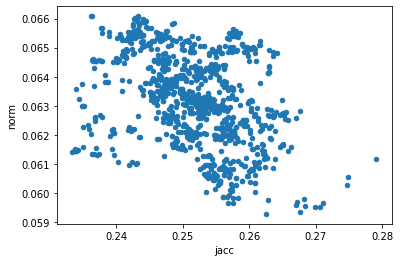

In [131]:
df_info.plot.scatter(x='jacc',y='norm')

<AxesSubplot:xlabel='jacc', ylabel='norm'>

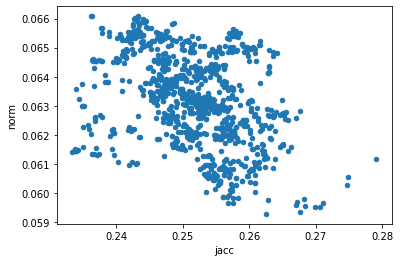

In [127]:
df_info.plot.scatter(x='jacc',y='norm')

In [143]:
list_norm = []
list_jacc = []

for i in range(1000):
    a = np.random.uniform(0,1,100)
    b = np.random.uniform(0,1,100)
    norm = np.mean(np.abs(a-b))
    thr_edge = 0.1
    dist =np.abs((a>thr_edge).astype(int) - (b>thr_edge).astype(int)).sum().sum()/2
    union = (((a>thr_edge).astype(int) + (b>thr_edge).astype(int))!=0).sum().sum()
    dist = dist/union
    list_norm.append(norm)
    list_jacc.append(dist)

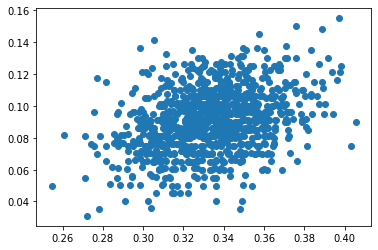

In [145]:
plt.scatter(list_norm,list_jacc)

In [140]:
dist

0.065

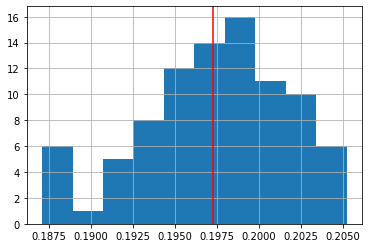

In [64]:
df_info = df_info.sort_values('it')
df_info['perm_array'] = diff_pcor_rep
df_info.query('len_re>7*10**7 and len_re<8*10**7').perm_array.hist()
plt.axvline(diff_control_case,c='r')

In [81]:
def get_random_same_region_length(df_gene_position,n_genes,length_area,it):
    np.random.seed(it)
    while True:
        start_gene = np.random.randint(0,df_gene_position.shape[0])
        start_pos_rnd = df_gene_position.iloc[start_gene].chrStart
        end_pos = start_pos_rnd + length_area
        tmp_chr = df_gene_position.iloc[start_gene].chr
        if end_pos<=df_gene_position.query('chr ==@tmp_chr').chrEnd.max()+2*10**6:
            selected_genes = list(set(df_gene_position.query('chrStart >= @start_pos_rnd and chrStart <= @end_pos and chr ==@tmp_chr').geneName))
            len_re = end_pos-start_pos_rnd
            ng = len(selected_genes)
            break

    return int(tmp_chr),start_pos_rnd,len_re,ng#,list(selected_genes)
l = [get_random_same_region_length(df_gene_position,n_genes,length_area,x) for x in range(1000)]

In [112]:
df_gene_position.query('chr=="21"').pipe(lambda x: x.chrStart.max()-x.chrStart.min())

38423023

In [82]:
l = np.array(l)

(array([310., 149., 137.,  58.,  72.,  89.,  87.,  40.,  30.,  28.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <BarContainer object of 10 artists>)

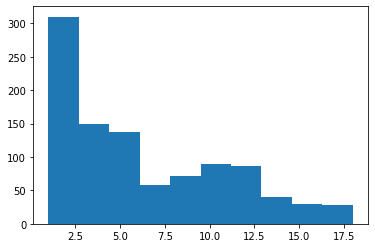

In [84]:
plt.hist(l[:,0])

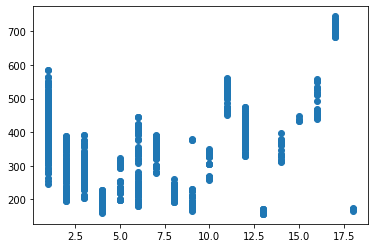

In [85]:
plt.scatter(l[:,0],l[:,-1])

AttributeError: 'DataFrame' object has no attribute 'chrEnd'

In [67]:
df_gene_position

,chrStart,Gene end (bp),chr,geneName
Gene stable ID,,,,
ENSG00000158270,316737,500722,18,COLEC12
ENSG00000264575,5236724,5238598,18,LINC00526
ENSG00000141401,11981025,12030877,18,IMPA2
ENSG00000168461,9708275,9862551,18,RAB31
ENSG00000271672,15826566,15827187,22,DUXAP8
...,...,...,...,...
ENSG00000067208,92508696,92792404,1,EVI5
ENSG00000143774,228139962,228148984,1,GUK1
ENSG00000169991,18904280,18956676,1,IFFO2


### LTRC Case Control Difference

### Info Sampling

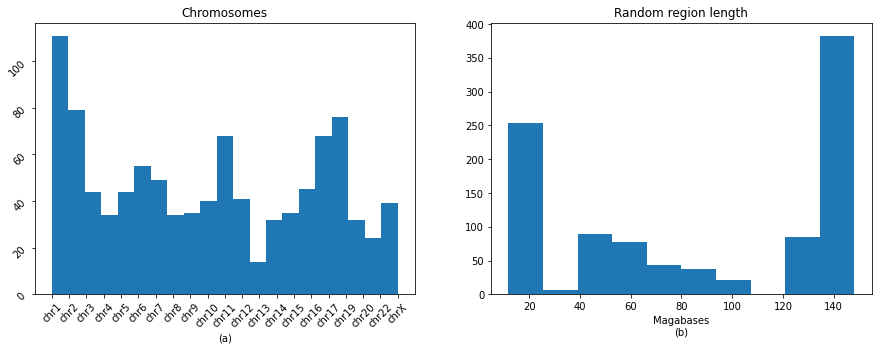

In [180]:
df_info = pd.read_csv('../data/Pcorr_output/Permutation_new/LTRC/Info_sampling_same_region_ngenes_minL_1_nreg_10.csv',index_col=0)
fig, axs = plt.subplots(1, 2,figsize=[15,5])
axs[0].hist(sorted(df_info.chrom,key= lambda x: int(x.replace('chr','').replace('X','1000').replace('M','1000').replace('Y','1000'))),
             bins=len(set(df_info.chrom)))
axs[0].set_title('Chromosomes')
axs[0].tick_params(labelrotation=45)
axs[0].set_xlabel('(a)')
#axs[1,0].hist(df_info.start_pos)
#axs[1,0].set_title('Random region start position')
axs[1].hist(df_info.len_re/10**6)
axs[1].set_title('Random region length')
axs[1].set_xlabel('Magabases\n(b)')
#axs[1].ticklabel_format(axis='x', style='sci', scilimits=(6,6))
#axs[1,1].hist(df_info.ng)
#axs[1,1].set_title('Random region n genes')
plt.savefig('../figures/S. Figure 3 Region Sampling details.pdf',bbox_inches= 'tight')

<AxesSubplot:xlabel='len_re', ylabel='diff'>

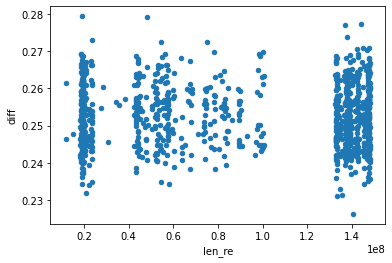

In [189]:
diff_pcor_rep, diff_control_case = Analysis_rnd_gene_set_diff('LTRC',random_type='same_region_ngenes',recompute =True,
                                                              minL=1,nreg=10,n_rep = 1000)
plt.savefig('../figures/Figure 7b.pdf',bbox_inches= 'tight')
print('Jaccard Distance observed:',diff_control_case)
print('Pvalue:',1-np.mean(diff_control_case >= np.array(diff_pcor_rep)))

df_info['diff'] = diff_pcor_rep
df_info.plot.scatter(x='len_re',y='diff')

## Old

#### Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:30<00:00,  6.65it/s]


same_region_ngenes 0.0


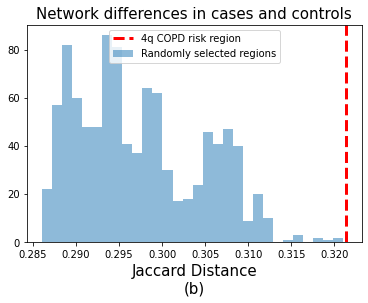

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:09<00:00,  3.23it/s]


same_region_lenght 0.09409409409409408


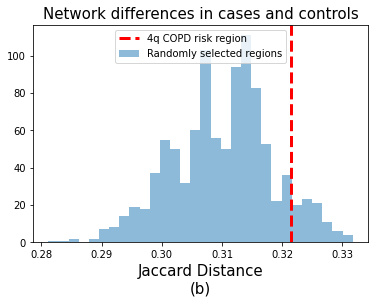

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:04<00:00,  5.41it/s]


scattered_same_ngenes 0.20620620620620622


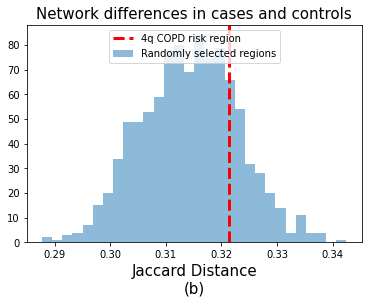

In [17]:
for random_type in ['same_region_ngenes','same_region_lenght','scattered_same_ngenes']:
    diff_pcor_rep, diff_control_case = Analysis_rnd_gene_set_diff('LTRC',random_type=random_type,recompute=True
                                                                  ,minL=1,nreg=10,n_rep = 1000)
    print(random_type,1-np.mean(diff_control_case >= np.array(diff_pcor_rep)))
    plt.show()

## GSE

### GSE23352 - Laval

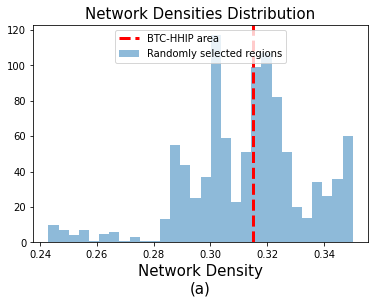

0.49949949949949946

In [42]:
density_rep_case, density_pcor_case = Analysis_rnd_gene_set_density('GSE',random_type='same_region_ngenes',pop='GSE23352',minL=1,nreg=10,n_rep = 1000)
1-np.mean(density_pcor_case < np.array(density_rep_case))

### GSE23529 - UBC

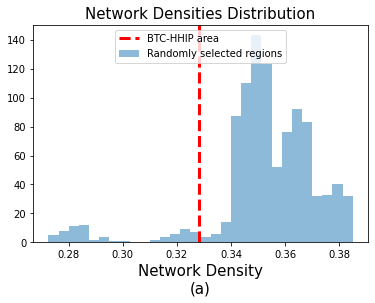

0.07207207207207211

In [43]:
density_rep_case, density_pcor_case = Analysis_rnd_gene_set_density('GSE',random_type='same_region_ngenes',pop='GSE23529',minL=1,nreg=10,n_rep = 1000)
1-np.mean(density_pcor_case < np.array(density_rep_case))

### GSE23545 - Groningen

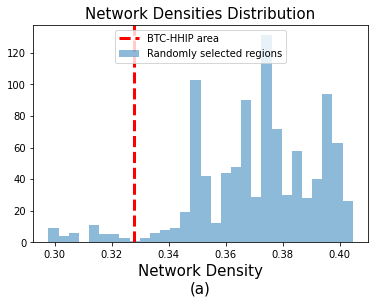

0.04304304304304307

In [44]:
density_rep_case, density_pcor_case = Analysis_rnd_gene_set_density('GSE',random_type='same_region_ngenes',pop='GSE23545',minL=1,nreg=10,n_rep = 1000)
1-np.mean(density_pcor_case < np.array(density_rep_case))

### DIFFERENCE

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.75it/s]


0.07907907907907907

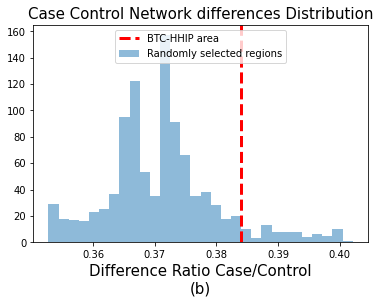

In [131]:
diff_pcor_rep, diff_control_case = Analysis_rnd_gene_set_diff('GSE',random_type='same_region_ngenes',minL=1,nreg=10,n_rep = 1000,recompute=True,case='GSE23545',control='GSE23529')
1-np.mean(diff_control_case >= np.array(diff_pcor_rep))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.74it/s]


0.38538538538538536

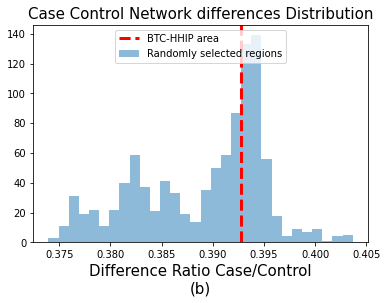

In [132]:
diff_pcor_rep, diff_control_case = Analysis_rnd_gene_set_diff('GSE',random_type='same_region_ngenes',minL=1,nreg=10,n_rep = 1000,recompute=True,case='GSE23352',control='GSE23529')
1-np.mean(diff_control_case >= np.array(diff_pcor_rep))

## Look at the Random selection

In [51]:
def get_df_gene_position(set_genes_in_gex,start_pos,stop_pos):
    df_gene_position = pd.read_csv(path_data+'Gene_location_clean.txt',sep=',',index_col=0)
    df_gene_position = df_gene_position.rename(columns={'#chrom':'chrom'}).query('geneName in @set_genes_in_gex')
    df_gene_position = df_gene_position[~df_gene_position['chrom'].str.contains('_')]
    df_gene_position = df_gene_position.set_index('geneName')

    genes_btc_hhip = set(df_gene_position.query('chrom =="chr4" and chromStart<=@stop_pos and chromStart>=@start_pos ').index)
    n_genes =len(genes_btc_hhip)
    lenght_area = stop_pos-start_pos
    print('N genes:',n_genes)
    print('N genes exp:',df_exp.shape)
    print('N genes intersection:',len(set(genes_btc_hhip).intersection(df_exp.index)))
    return df_gene_position,n_genes,lenght_area,genes_btc_hhip




path_data= '../data/' # your path to remge/data/
path_output_dir = path_data + "Pcorr_output/" 
list_nreg = [10]#[0,1,5,10,25,50,75,100]
list_minL = [1]
chromosome = 'All'

start_pos = 74748153-2*10**6 #rs4585380
stop_pos = 144567946+2*10**6 #rs13140176

import sys
sys.path.append('../src/')
from Preprocessing import load_GENE_expression
gex_name='LTRC'
path_results = path_output_dir + 'Permutation/'+gex_name+'/'
print(path_results)
os.makedirs(path_results,exist_ok=True)
df_exp, dict_pop = load_GENE_expression(gex_name,chromosome=chromosome,path_data=path_data)

set_genes_in_gex = set(df_exp.index)
df_gene_position,n_genes,lenght_area,genes_btc_hhip = get_df_gene_position(set_genes_in_gex,start_pos,stop_pos)




In [125]:
def get_random_gene_list(random_type,df_gene_position,n_genes,lenght_area):
    
    # chromosome might bee too short or too few genes:
    while True:
        chrom = np.random.choice(df_gene_position.chrom)
        df_gene_in_chr = df_gene_position.query('chrom==@chrom')
    
        try:
            if random_type == 'scattered_same_ngenes':
                selected_genes = np.random.choice(df_gene_position.index, replace=False,size=n_genes)
    
            elif random_type == 'same_region_lenght':
                max_pos = df_gene_in_chr.chromStart.max()
                start_pos = np.random.choice(df_gene_in_chr.query('chromStart+@lenght_area < @max_pos').chromStart)
                end_pos = start_pos + lenght_area
                selected_genes = df_gene_position.query('chrom == @chrom and chromStart >= @start_pos and chromStart <= @end_pos').index
            elif random_type == 'same_region_ngenes':
                start_gene = np.random.randint(0,df_gene_in_chr.shape[0]-n_genes)
                selected_genes = df_gene_position.iloc[start_gene:start_gene+n_genes].index
        except Exception as e: 
            #print(e)
            continue
        break
    start_pos = df_gene_position.loc[list(selected_genes)].chromStart.min()
    end_pos = df_gene_position.loc[list(selected_genes)].chromStart.max()
    len_re = end_pos-start_pos
    ng = len(selected_genes)
    return chrom,start_pos,len_re,ng,list(selected_genes)

list_chrom = []
list_start = []
list_len = []
list_ng = []

for i in tqdm(range(10000)):
    
    chrom,start_pos,len_re,ng,list_genes = get_random_gene_list('same_region_ngenes',df_gene_position,n_genes,lenght_area)
    list_chrom.append(chrom)
    list_start.append(start_pos)
    list_len.append(len_re)
    list_ng.append(ng)
    
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:16<00:00, 130.63it/s]


<AxesSubplot:>

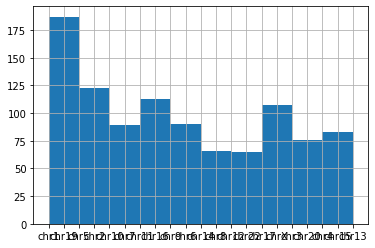

In [ ]:
df_info.chrom.hist()

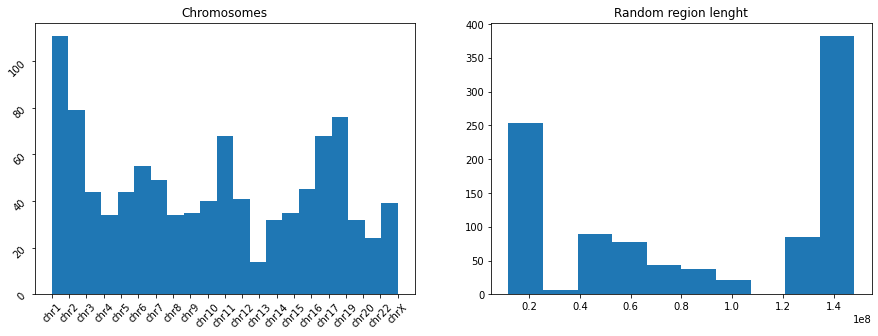